In [368]:
import pandas as pd
import numpy as np
flows = pd.read_csv('lanl_flows.csv')

In [369]:
flows.head()

,time,duration,source_computer,source_port,destination_computer,destination_port,protocol,packet_count,byte_count
0,471692,0,C5808,N24128,C26871,N17023,6,1,60
1,471692,0,C5808,N2414,C26871,N19148,6,1,60
2,471692,0,C5808,N24156,C26871,N8001,6,1,60
3,471692,0,C5808,N24161,C26871,N18502,6,1,60
4,471692,0,C5808,N24162,C26871,N11309,6,1,60


In [370]:
flows_grouped = flows.groupby('destination_computer')

In [371]:
list(flows_grouped)[0]

('C10047',
         time  duration source_computer source_port destination_computer  \
 2791  471694         0           C2109         389               C10047   
 2792  471694         0           C2109         389               C10047   
 2793  471694         0           C2109          88               C10047   
 2794  471694         0           C2109          88               C10047   
 2799  471694         0            C467         389               C10047   
 2800  471694         0            C467         389               C10047   
 2801  471694         0            C467         389               C10047   
 2802  471694         0            C467         389               C10047   
 2825  471694        12           C2109         135               C10047   
 2832  471694        14            C625         445               C10047   
 2834  471694         2           C2109         389               C10047   
 2841  471694        32           C2109        N204               C10047   
 

In [372]:
def featurize(df):
    return {
        'unique_ports' :len(set(df['destination_port'])),
        'average_packet' : np.mean(df['packet_count']),
        'average_duration' : np.mean(df['duration'])
    }

In [373]:
out = flows.groupby('destination_computer').apply(featurize)

In [374]:
X = pd.DataFrame(list(out), index=out.index)
X.head()

,unique_ports,average_packet,average_duration
destination_computer,,,
C10047,13,20.692308,7.538462
C10054,1,4.000000,0.000000
C10131,1,4.000000,55.000000
C1015,1,1.000000,0.000000
C10235,1,9.000000,0.000000


In [375]:
attacks = pd.read_csv('redteam.csv')
attacks.head()

,time,user_domain,source_computer,destination_computer
0,151036,U748@DOM1,C17693,C305
1,151648,U748@DOM1,C17693,C728
2,151993,U6115@DOM1,C17693,C1173
3,153792,U636@DOM1,C17693,C294
4,155219,U748@DOM1,C17693,C5693


In [376]:
bads = set(attacks['source_computer'].append(attacks['destination_computer']))

In [377]:
y = [x in bads for x in X.index]

In [378]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy_score(y_test, predictions)

0.9352941176470588

In [379]:
print(np.mean(cross_val_score(AdaBoostClassifier(), X, y)))

0.9238938053097344


In [380]:
protocols = flows.groupby('source_computer').apply(lambda df: len(set(df['protocol'])))

In [381]:
protocols.value_counts()

1    525
2     57
3     13
dtype: int64

In [382]:
protocols.index

Index(['C10', 'C10026', 'C10047', 'C1015', 'C10235', 'C10297', 'C10326',
       'C10328', 'C10366', 'C10380',
       ...
       'C9741', 'C9804', 'C9827', 'C9835', 'C9860', 'C9873', 'C993', 'C9937',
       'C9941', 'C997'],
      dtype='object', name='source_computer', length=595)

In [383]:
protocols_df = pd.DataFrame(protocols, index=protocols.index, columns=['protocol'])

In [384]:
protocols_df.head()

,protocol
source_computer,
C10,1
C10026,1
C10047,2
C1015,1
C10235,1


In [385]:
protocols_df.index

Index(['C10', 'C10026', 'C10047', 'C1015', 'C10235', 'C10297', 'C10326',
       'C10328', 'C10366', 'C10380',
       ...
       'C9741', 'C9804', 'C9827', 'C9835', 'C9860', 'C9873', 'C993', 'C9937',
       'C9941', 'C997'],
      dtype='object', name='source_computer', length=595)

In [386]:
X.index

Index(['C10047', 'C10054', 'C10131', 'C1015', 'C10235', 'C10297', 'C10326',
       'C10328', 'C10366', 'C10380',
       ...
       'C9812', 'C9827', 'C9835', 'C9860', 'C9873', 'C993', 'C9937', 'C9941',
       'C9943', 'C997'],
      dtype='object', name='destination_computer', length=565)

In [387]:
#X_more = pd.merge(X, protocols_df, left_index=True, right_index=True) # inner join
#X_more = pd.concat([X, protocols_df], axis=1) # outer join
X_more = X.join(protocols_df) # left join

In [388]:
X_more.protocol.fillna(0, inplace=True)

In [389]:
X_more

,unique_ports,average_packet,average_duration,protocol
destination_computer,,,,
C10047,13,20.692308,7.538462,2.0
C10054,1,4.000000,0.000000,0.0
C10131,1,4.000000,55.000000,0.0
C1015,1,1.000000,0.000000,1.0
C10235,1,9.000000,0.000000,1.0
...,...,...,...,...
C993,2,4.000000,0.000000,1.0
C9937,4,8.500000,9.000000,2.0
C9941,1,3.000000,45.000000,1.0


In [390]:
y_more = [x in bads for x in X_more.index]

In [391]:
y.count(False)

528

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X_more, y_more, stratify=y, test_size=0.3)
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy_score(y_test, predictions)

0.9235294117647059

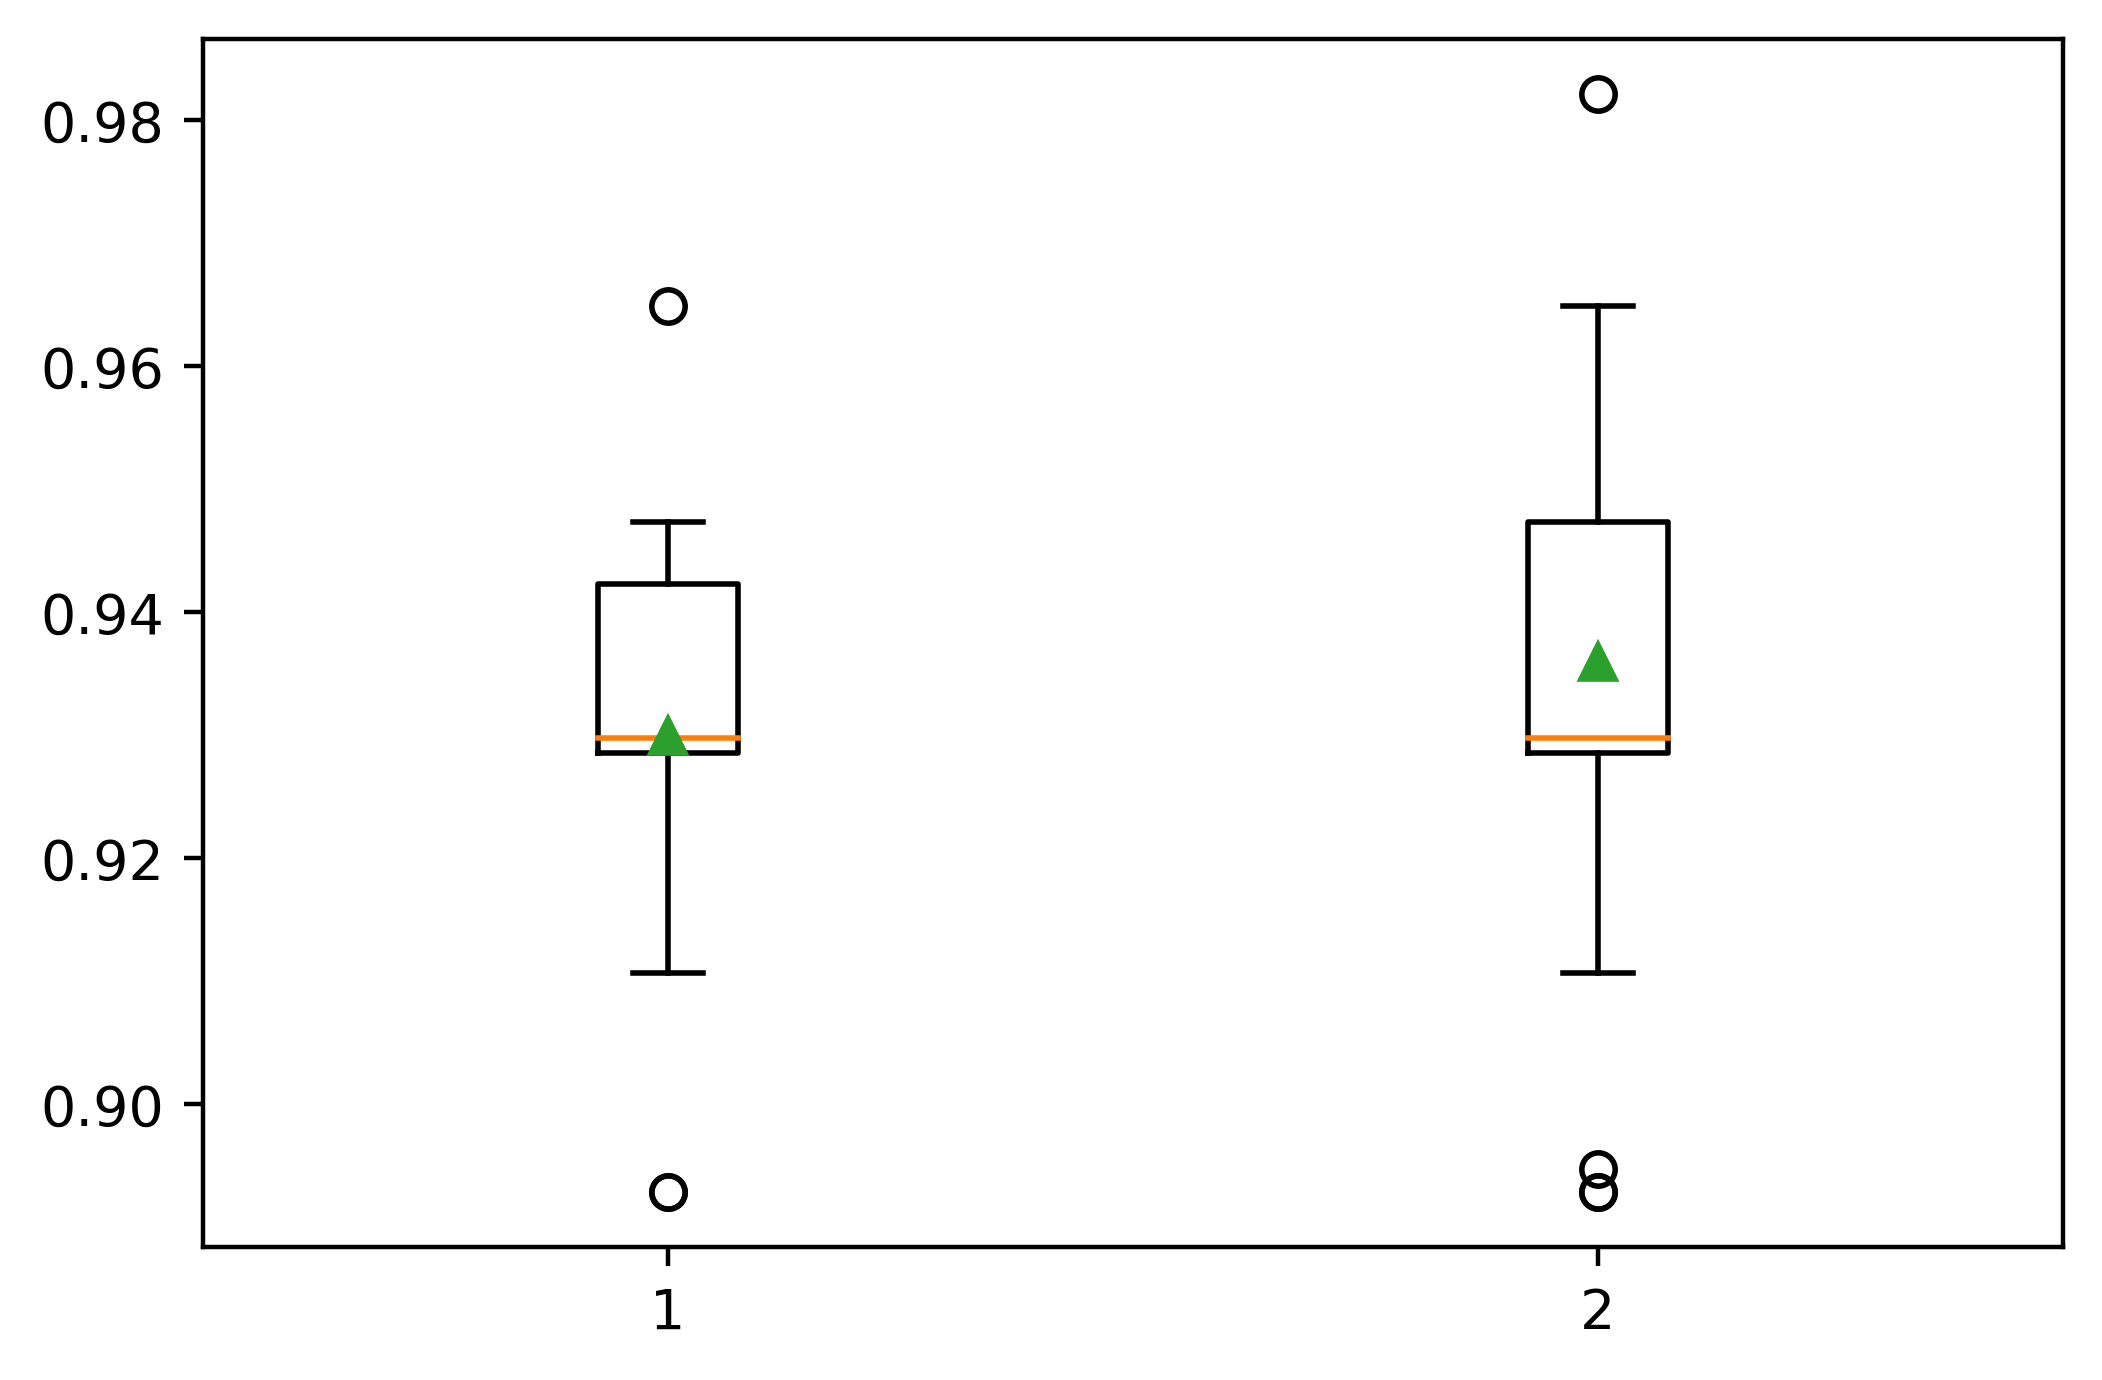

In [393]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
import matplotlib as mpl
mpl.rcParams['figure.dpi']=400

model = AdaBoostClassifier()
datasets = [(X, y), (X_more, y_more)]
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores


# evaluate the models and store results
results, names = list(), list()
for X, y in datasets:
    scores = evaluate_model(model, X, y)
    results.append(scores)
    #names.append(X)
    #print('>%s %.3f (%.3f)' % (mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, showmeans=True)
pyplot.show()

In [394]:
X_bad = X_more[y_more]
avg_bad_ports = np.mean(X_bad['unique_ports'])
y_weak = X_bad['unique_ports'] > avg_bad_ports

X_aug = pd.concat([X_more, X_bad])
y_aug = pd.concat([pd.Series(y_more), pd.Series(y_weak)])

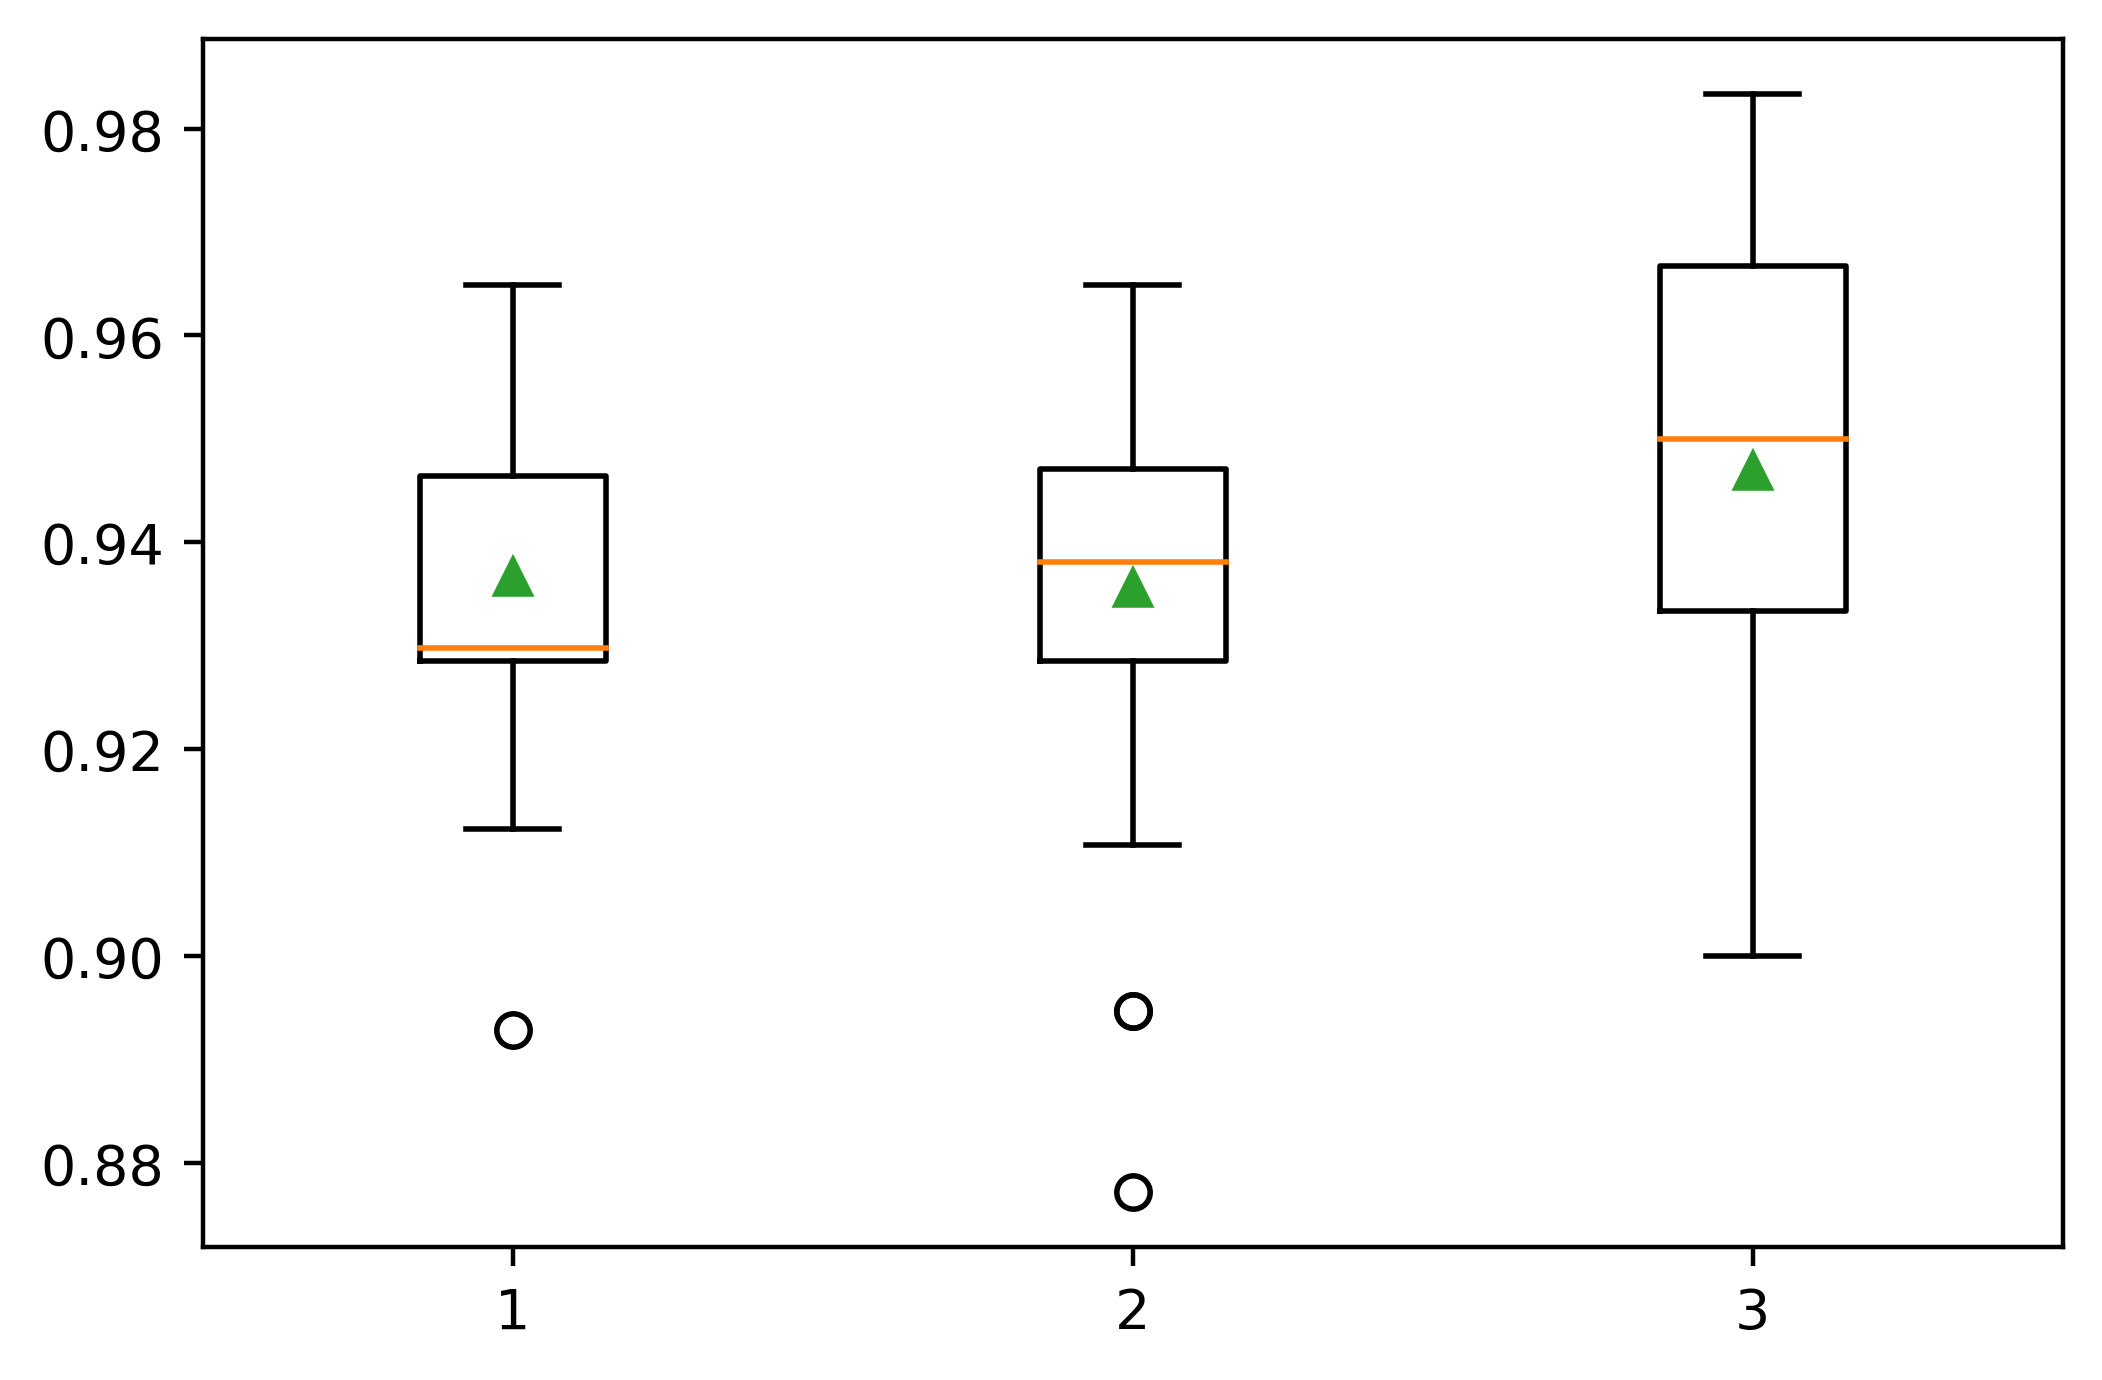

In [395]:
model = AdaBoostClassifier()
datasets = [(X, y), (X_more, y_more), (X_aug, y_aug)]
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores


# evaluate the models and store results
results, names = list(), list()
for X, y in datasets:
    scores = evaluate_model(model, X, y)
    results.append(scores)
    #names.append(X)
    #print('>%s %.3f (%.3f)' % (mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, showmeans=True)
pyplot.show()

In [396]:
X_bad2 = X_more[y_more]

avg_bad_ports = np.mean(X_more[y_more]['unique_ports'])
pred_port = X_bad2['unique_ports'] > avg_bad_ports

avg_bad_packet =  np.mean(X_more[y_more]['average_packet'])
pred_packet = X_bad2['average_packet'] < avg_bad_packet

y_weak_train2 = pred_port*pred_packet

X_aug2 = pd.concat([X_more, X_bad2])
y_aug2 = pd.concat([pd.Series(y_more), pd.Series(y_weak_train2)])

C:\Users\psahai\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


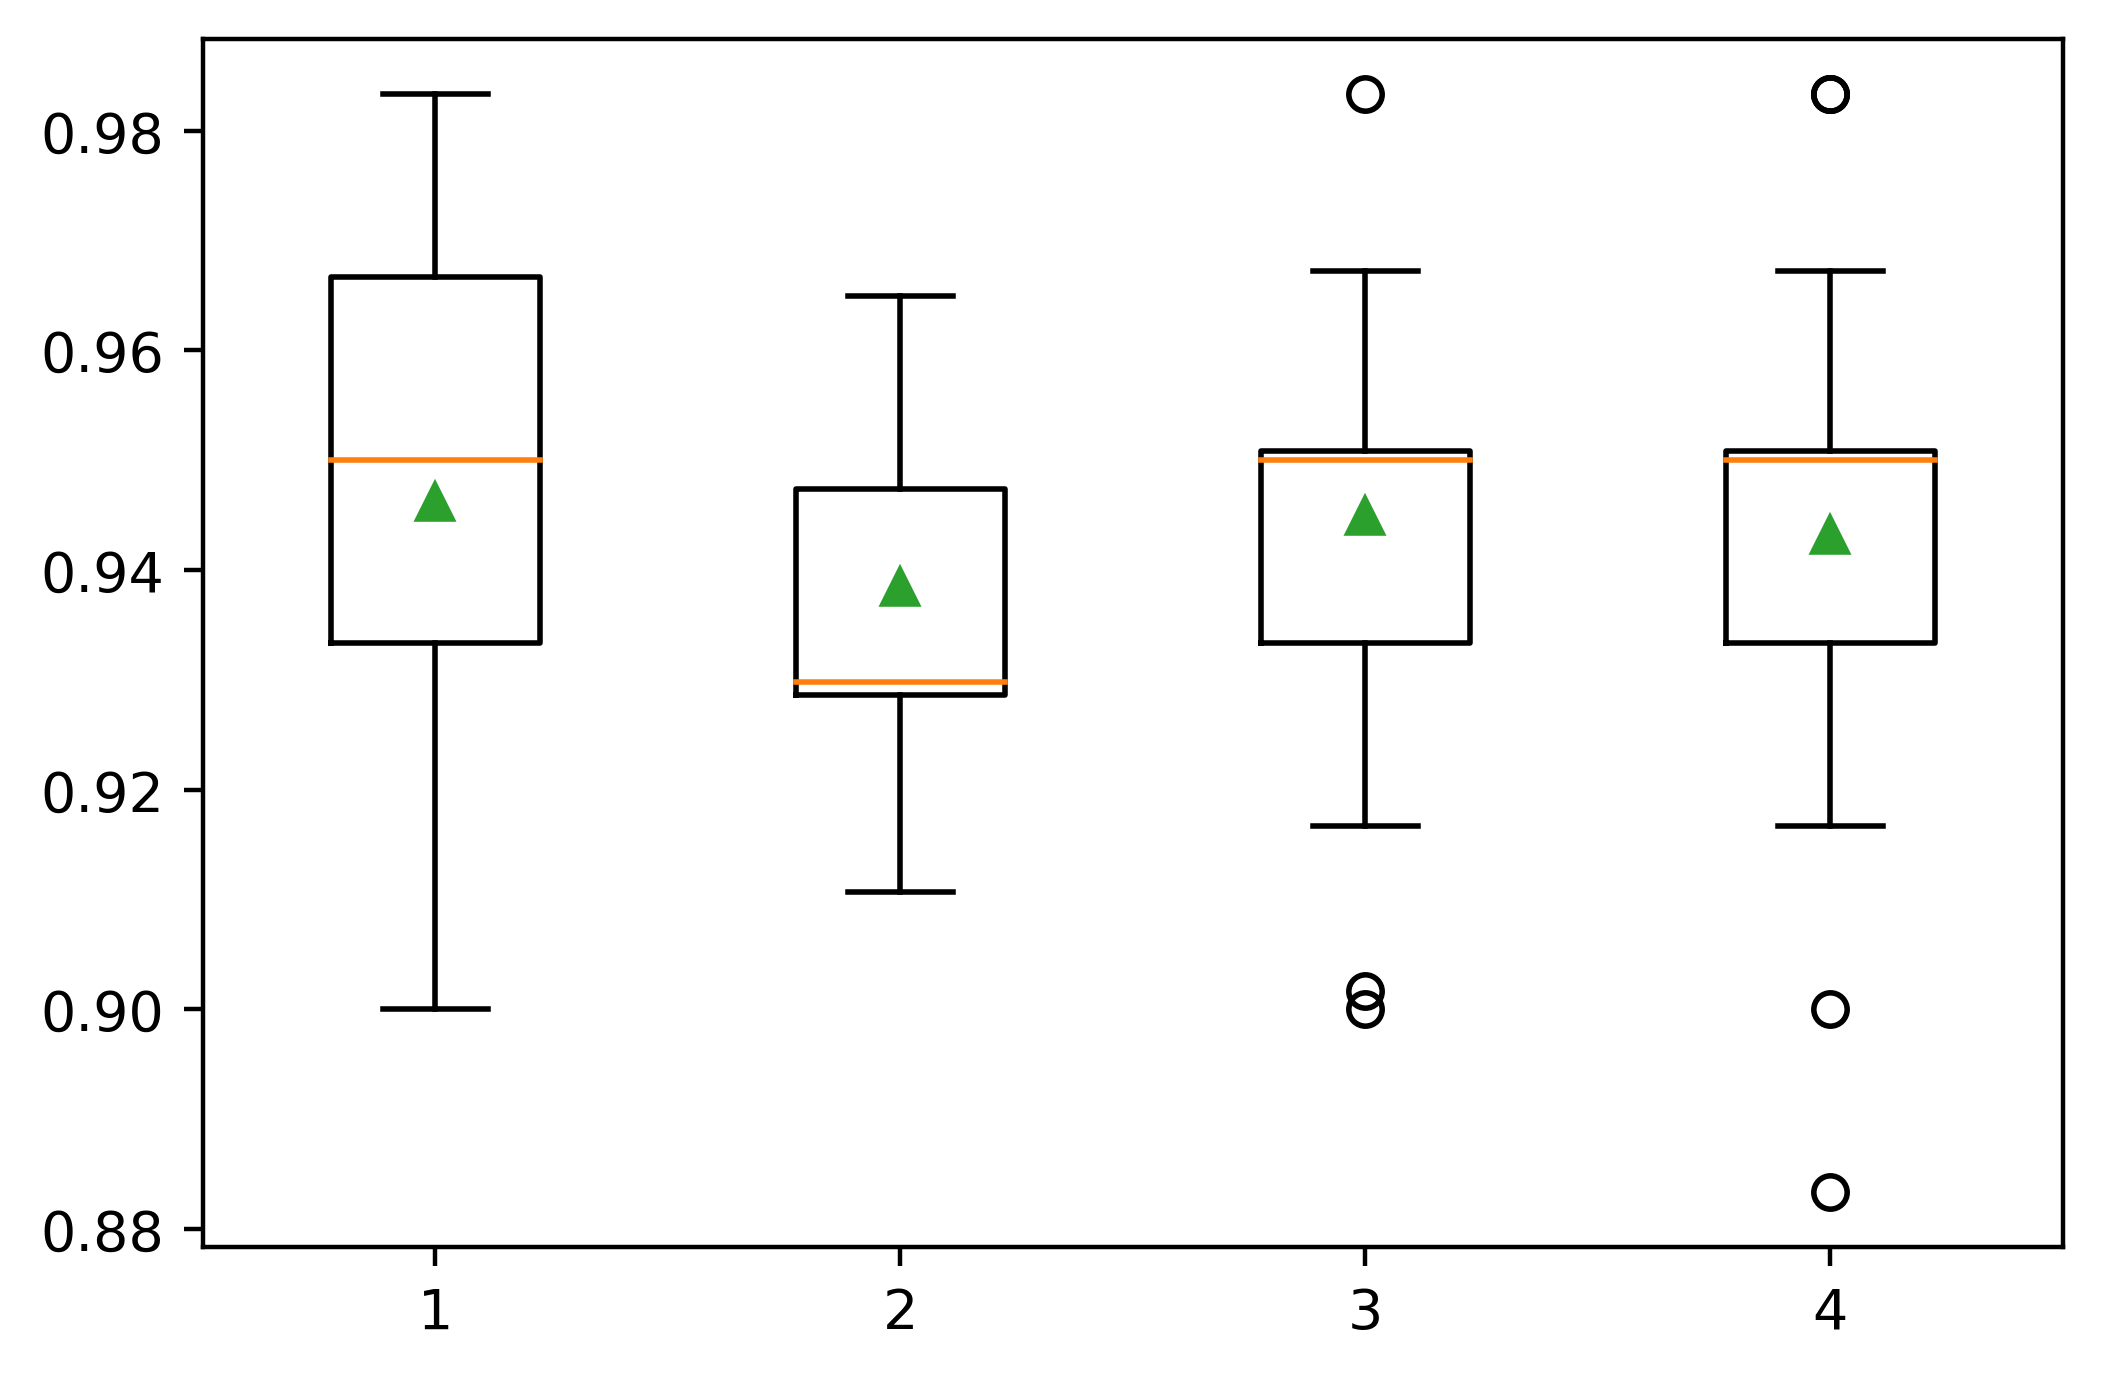

In [397]:
model = AdaBoostClassifier()
datasets = [(X, y), (X_more, y_more), (X_aug, y_aug), (X_aug2, y_aug2) ]
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores


# evaluate the models and store results
results, names = list(), list()
for X, y in datasets:
    scores = evaluate_model(model, X, y)
    results.append(scores)
    #names.append(X)
    #print('>%s %.3f (%.3f)' % (mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, showmeans=True)
pyplot.show()

In [398]:
from sklearn.naive_bayes import GaussianNB
# Fit a Gaussian Naive Bayes classifier to the training data
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, stratify=y, test_size=0.3)
#clf = GaussianNB().fit(X_train, y_train)
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy_score(y_test, predictions)

0.9337016574585635